### Import all necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
import time
from sklearn.metrics import confusion_matrix
import pandas as pd

Using TensorFlow backend.


### Data Import

In [2]:
from keras.datasets import fashion_mnist
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

### Getting to know the data

In [3]:
type(x_train)

numpy.ndarray

In [4]:
type(y_train)

numpy.ndarray

In [5]:
type(x_test)

numpy.ndarray

In [6]:
type(y_test)

numpy.ndarray

All four datasets are numpy arrays.

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
y_train.shape

(60000,)

In [9]:
x_test.shape

(10000, 28, 28)

In [10]:
y_test.shape

(10000,)

There are 60000 samples in train data and 10000 samples in test data

In [11]:
y_train[:20]
# To see the 1st 20 labels

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4],
      dtype=uint8)

Labels are integers ranging from [0, 9]. So, they need to be one-hot-encoded.

Let's visulaize few samples of data

In [12]:
r_choices = np.random.choice(range(len(y_train)), 3, replace=False)

In [13]:
label_ref = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# Taken from Zalando github repo

Plot of Sandal


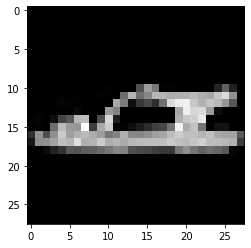

In [14]:
print("Plot of {}".format(label_ref[y_train[r_choices[0]]]))
plt.imshow(x_train[r_choices[0]], cmap='gray')

Plot of Sneaker


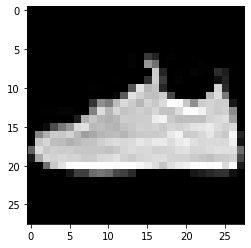

In [15]:
print("Plot of {}".format(label_ref[y_train[r_choices[1]]]))
plt.imshow(x_train[r_choices[1]], cmap='gray')

Plot of Ankle boot


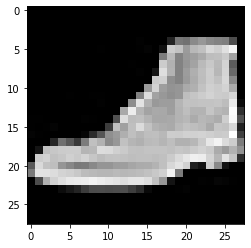

In [16]:
print("Plot of {}".format(label_ref[y_train[r_choices[2]]]))
plt.imshow(x_train[r_choices[2]], cmap='gray')

Let's see the values of one image sample

In [17]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

The greyscale values range from 0 to 255. So, these values need to be normalized.

### Data Preprocessing

In [18]:
# Normalizing the data
x_train = x_train / 255
x_test = x_test / 255

In [19]:
# One-hot-encoding the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Each image in the data is in the form of (28,28). For Keras to be able to read this image, it has to be reshaped to (28,28,1).

In [20]:
im_width = x_train[0].shape[0]
im_height = x_train[0].shape[1]
x_train = x_train.reshape(x_train.shape[0], im_width, im_height, 1)
x_test = x_test.reshape(x_test.shape[0], im_width, im_height, 1)

### Creating neural network

In [21]:
model = Sequential()

# 1st CNN layer
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))

# 2nd CNN layer
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

# 2 dense layers
model.add(Dense(313, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics=['accuracy'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 313)               981881    
_________________________________________________________________
dropout_1 (Dropout)          (None, 313)               0         
__________

In [23]:
# Creating an inherited class to get and save training metrics
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []
        self.val_loss = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

history = AccuracyHistory()        

In [24]:
# To save the neural network
checkpointer = ModelCheckpoint(filepath='best_model.hdf5', verbose = 1, save_best_only=True)

### Training the network

In [25]:
tr_past = time.time()

In [26]:
model.fit(x_train, y_train, batch_size=120, epochs=10, validation_split=0.09 , callbacks=[history,checkpointer])

Train on 54600 samples, validate on 5400 samples
Epoch 1/11
54600/54600 [==============================] - 55s 1ms/step - loss: 0.4944 - acc: 0.8246 - val_loss: 0.3265 - val_acc: 0.8789

Epoch 00001: val_loss improved from inf to 0.32646, saving model to best_model.hdf5
Epoch 2/11
54600/54600 [==============================] - 52s 953us/step - loss: 0.3152 - acc: 0.8875 - val_loss: 0.2701 - val_acc: 0.8994

Epoch 00002: val_loss improved from 0.32646 to 0.27012, saving model to best_model.hdf5
Epoch 3/11
54600/54600 [==============================] - 63s 1ms/step - loss: 0.2746 - acc: 0.9001 - val_loss: 0.2622 - val_acc: 0.9013

Epoch 00003: val_loss improved from 0.27012 to 0.26217, saving model to best_model.hdf5
Epoch 4/11
54600/54600 [==============================] - 61s 1ms/step - loss: 0.2415 - acc: 0.9118 - val_loss: 0.2312 - val_acc: 0.9102

Epoch 00004: val_loss improved from 0.26217 to 0.23122, saving model to best_model.hdf5
Epoch 5/11
54600/54600 [=========================

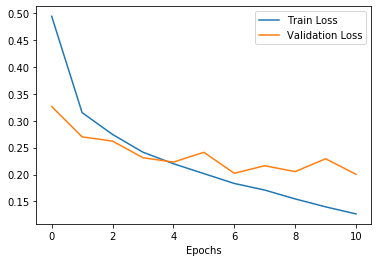

In [27]:
plt.plot(range(11), history.loss)
plt.plot(range(11), history.val_loss)
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

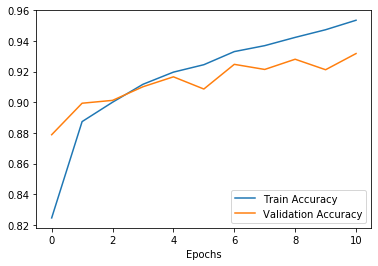

In [28]:
plt.plot(range(11), history.acc)
plt.plot(range(11), history.val_acc)
plt.xlabel('Epochs')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [29]:
print("Time taken for training: {} sec".format(time.time() - tr_past))

Time taken for training: 624.7655262947083 sec


### Testing the network

In [30]:
ts_past = time.time()

In [31]:
model.load_weights('best_model.hdf5')
model.evaluate(x_test, y_test, verbose=0)

[0.22544371454715728, 0.9229]

In [32]:
print("Time taken for testing evaluation: {} sec".format(time.time() - ts_past))

Time taken for testing evaluation: 2.796217679977417 sec


In [33]:
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#matrix = pd.DataFrame(data = matrix, index = label_ref, columns = label_ref)

In [34]:
tmp_acc = []
total_acc = 0
for i in range(len(matrix)):
    tmp_acc.append(matrix[i][i]/sum(matrix[i]))
    total_acc += matrix[i][i]
total_acc = total_acc/sum(sum(matrix))
last_row = [0 for i in range(10)]
last_row.append(total_acc)

In [35]:
df_matrix = pd.DataFrame(data = matrix, index = label_ref, columns = label_ref)
df_matrix['Accuracy'] = tmp_acc
df_matrix.loc['Total Accuracy'] = last_row

In [36]:
def add_color(value):
    if value < total_acc:
        color = 'red'
    elif value >= total_acc:
        color = 'green'
    return 'color: %s' % color

df_matrix_sty = df_matrix.style.applymap(add_color, subset=['Accuracy'])

In [37]:
df_matrix_sty

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot,Accuracy
T-shirt/top,896,0,18,13,6,1,61,0,5,0,0.896
Trouser,0,986,0,9,3,0,1,0,1,0,0.986
Pullover,16,1,900,6,43,0,33,0,1,0,0.9
Dress,15,5,5,917,37,0,17,0,4,0,0.917
Coat,1,0,46,12,915,0,26,0,0,0,0.915
Sandal,0,0,0,0,0,987,0,7,0,6,0.987
Shirt,123,0,59,27,79,0,703,0,9,0,0.703
Sneaker,0,0,0,0,0,12,0,968,0,20,0.968
Bag,2,1,1,4,0,1,1,3,987,0,0.987
Ankle boot,0,0,0,0,0,3,1,26,0,970,0.97
